In [1]:
import cv2, os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import shutil
from scores import score_in_details
from torchensemble.utils import io
import torch_directml
from torchensemble.gradient_boosting import GradientBoostingClassifier
torch.manual_seed(240)

In [2]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size = (224, 224)),
        transforms.ToTensor(),
        ])

In [3]:
class MyDataset(Dataset):
    def __init__(self, ds, transform):
        self.ds = ds
        self.transform = transform
                
    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):            
        image_path = self.ds[idx][0]
        label = self.ds[idx][1]
        img = cv2.imread(image_path)
        img = self.transform(img)
            
        return {"image": img,
                "labels": label,
                "path": image_path}

In [4]:
dataset_path = "../splitted/test"
test_dataset = dsets.ImageFolder(root=f'{dataset_path}')
test_ds = MyDataset(ds=test_dataset.imgs, transform=transform)

In [5]:
test_loader = DataLoader(test_ds, batch_size=10, drop_last=True, shuffle=False)

In [12]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv =  nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=1, padding=0, bias=True),
                     nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                     nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
                                   
                     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=0, bias=True),
                     nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                     nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
                                   
                     nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=1, padding=0, bias=True),
                     nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                     nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
                                   
                     nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=1, padding=0, bias=True),
                     nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                     nn.MaxPool2d(kernel_size=3, stride=2, padding=0))

        
        self.dense = nn.Sequential(nn.Flatten(), 
                                  nn.Linear(512*11*11, 512),
                                  nn.ReLU(),
                                  nn.Linear(512, 256),
                                  nn.ReLU(),
                                  nn.Linear(256, 2))
                        
    def forward(self, x):
        x = self.conv(x)
        x = self.dense(x)
        
        return x

In [13]:
model = GradientBoostingClassifier(
    estimator=MyCNN,
    n_estimators=5,
    cuda=False)

In [14]:
model_path="../trained-models/ensemble-mycnn"
io.load(model, model_path, map_location=torch.device("cpu"))

In [15]:
dml = torch_directml.device()
model.to(dml)
model.eval()

GradientBoostingClassifier(
  (estimators_): ModuleList(
    (0-4): 5 x MyCNN(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
        (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [16]:
def get_predictions():
    softmax = nn.Softmax(dim=1)
    model.eval()
    predictions = []
    real_values = []
    pred_probas = []
    misclassified = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs = batch['image'].to(dml)
            labels = batch['labels']
            path = batch["path"]
            
            outputs = softmax(model(inputs))
            
            _, preds = torch.max(outputs, dim = 1)
            for probs in outputs.cpu():   
                pred_probas.append(list(probs.numpy()))
                
            preds = preds.cpu()
            labels = labels.cpu()
            predictions.extend(preds)
            real_values.extend(labels)
            
            for ind, (actual, pred) in enumerate(zip(labels, preds)):
                if actual != pred:
                    misclassified.append((path[ind], actual, pred))
            
    return predictions, real_values, pred_probas, misclassified

In [17]:
pred, real, probas, misclassified = get_predictions()
print(classification_report(real, pred, digits=6))

  0%|          | 0/1886 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0   0.974364  0.964866  0.969592      4924
           1   0.987629  0.991030  0.989327     13936

    accuracy                       0.984199     18860
   macro avg   0.980996  0.977948  0.979459     18860
weighted avg   0.984166  0.984199  0.984174     18860



Accuracy: 98.41993637327677%
Precision: 0.9841656047027165
Recall: 0.9841993637327677
F1-score: 0.984174250505837
MCC-score: 0.9589398245384076
ROC AUC score: 0.5483045069208106




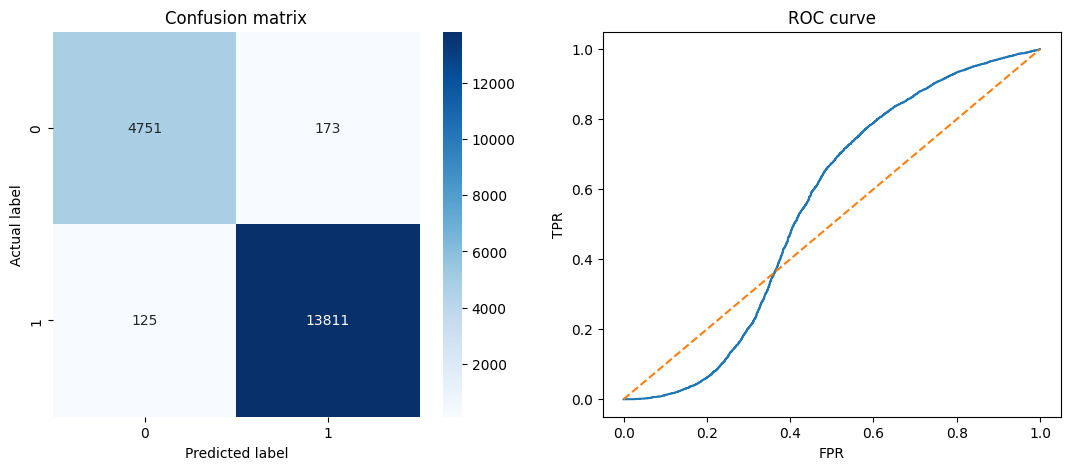

In [18]:
score_in_details(pred=pred, real=real, probas=probas)

In [13]:
dest = "../misclassified-new/gradient-boosting-normal-densenet"
cnt = 1
for path, actual, pred in tqdm(misclassified):
    img_name = path.split("\\")[-1].split(".")[0]
    ext = path.split(".")[-1]
    shutil.copy(path, os.path.join(dest, f"{cnt}_{img_name}_{actual.item()}_{pred.item()}.{ext}"))
    cnt += 1

  0%|          | 0/23 [00:00<?, ?it/s]